In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os,sys
import scipy.signal as signal
import math
# nicec plot style
plt.style.use('ggplot')

sys.path.insert(0, os.path.abspath('../lib'))
import file_read
import sig_proc as sp
import ecg


def palette(LED):
    if LED == 'G':
        c = 'green'
    elif LED == 'R':
        c = '#E24A33'
    else:
        c = '#348ABD'
    return c 

# Check multiple file

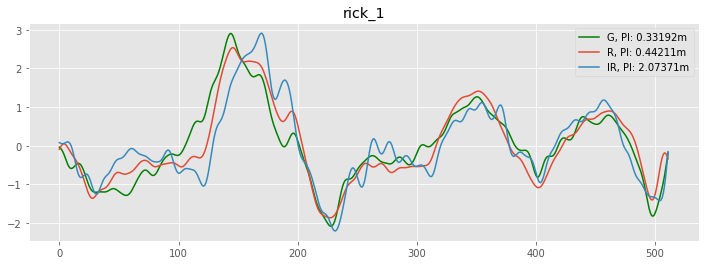

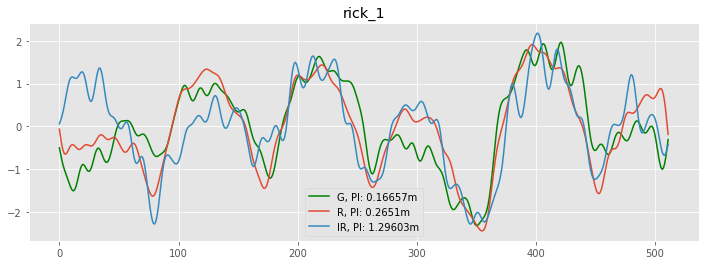

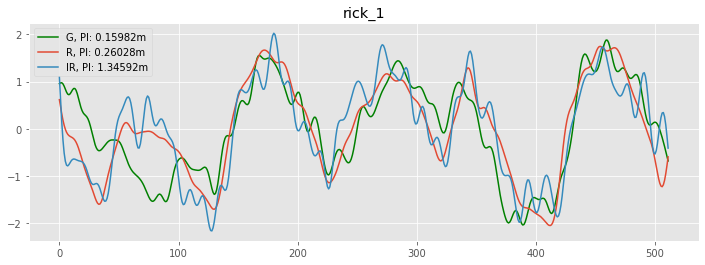

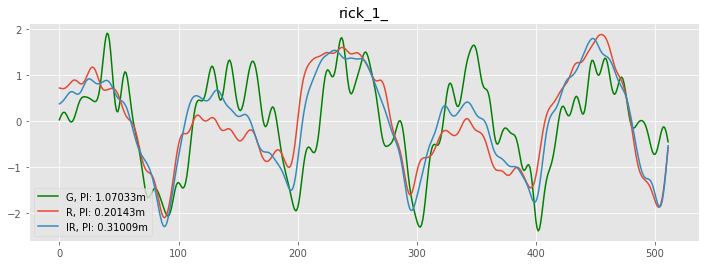

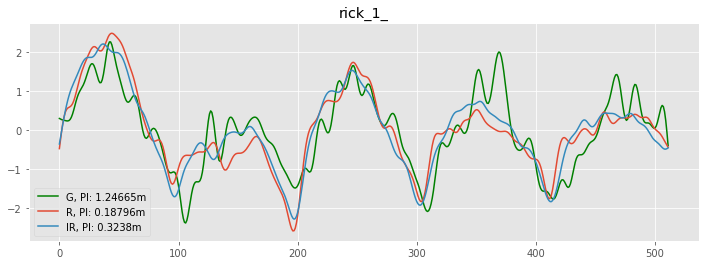

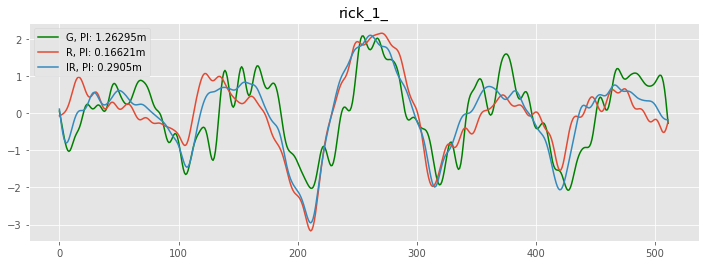

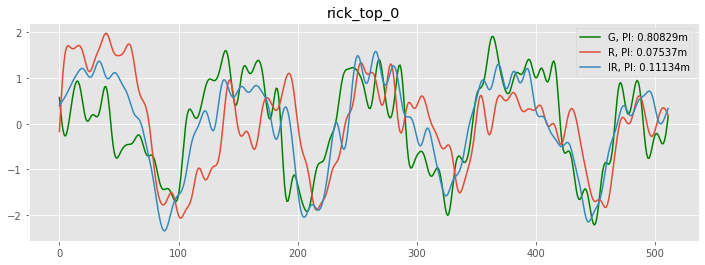

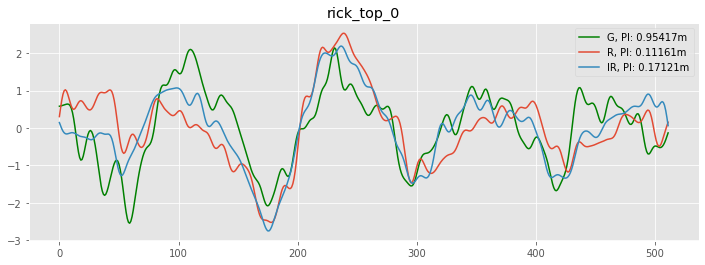

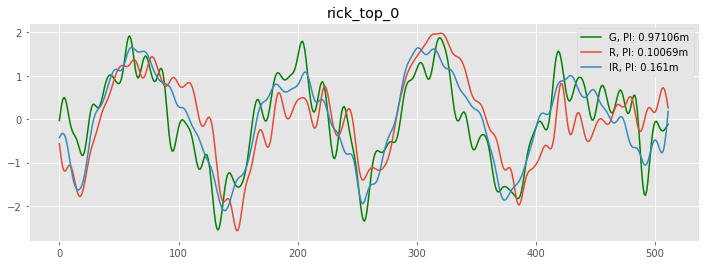

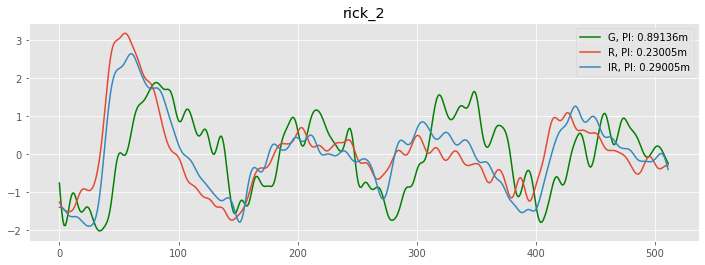

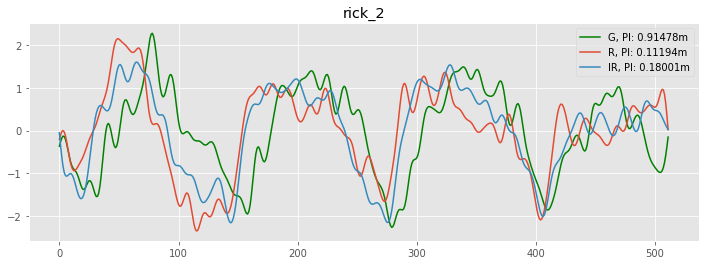

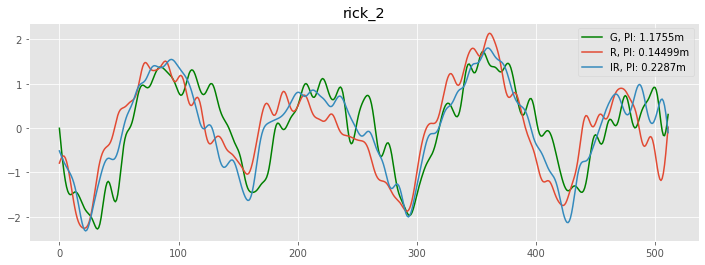

In [31]:

# 測試擺放位置 LU: 左上胸/ UC: 中上方/ f: finger
# folder = 'test/test2'
# subjects = ['rick_LU45', 'rick_UC45', 'rick_f', 'shawn_UC', 'shawn_LU']

#測試電流
# folder = 'test/current_test'
# subjects = ['ryan_LU_10mA','shawn_LU_10mA', 'ryan_UC_10mA', 'shawn_UC_10mA', 'shawn_f_5mA', 'shawn_f_10mA' ]


# 測試模組高度 normal vs 3mm
folder = 'test/module'
# subjects = ['rick_top_0', 'rick_bot_3', 'rick_top_3', 'rick_bot_0']  
subjects = ['rick_1', 'rick_1_', 'rick_top_0', 'rick_2']

# 測試運動
# folder = 'test/motion'
# subjects = ['shawn_0', 'shawn_3', 'shawn_3_']
# subjects = ['rick_stair_1mm', 'rick_stair_2mm', 'rick_walk_run_1mm', 'rick_walk_run_2mm', 'rick_0', 'rick_3']



'''overall parameters '''
# start_sec = 10

sr = 128
window = sr*4

# K1 = 99.813
# K2 = -4.615
K1 = 121.12
K2 = -51.77
LEDS= ['G', 'R', 'IR']
vital_sign={
    'subject':[],
    'HR':[],
    'G_HR':[],
    'R_HR':[],
    'IR_HR':[],
    'avg_HR':[],
    'spo2':[]
}
# Filter parameters
b, a = sp.bp_filter(0.5, 10, sr, 4)

for subject in subjects:
    file_name = subject
    full_file_path = os.path.join("../../data", 'stark', folder, file_name)
    ppg_data= file_read.csv_reader(full_file_path, 'ppg')
    ecg_data= file_read.csv_reader(full_file_path, 'ecg') 
    for start_sec in range(0, 12, 4):
        PI_list={head:[] for head in LEDS}
        PPG_LIST={head:[] for head in LEDS}
        
        
        s1 = start_sec*sr
        s2 = s1+window 

        ecg_sample = ecg_data['ecg'][s1:s2]
        ecg_proc = ecg.ecg_preprocess(ecg_sample, sr)
        ecg_proc = np.array(ecg_proc)
        ecg_hr, rpeak = ecg.ecg_hr_estimate(ecg_proc, sr)

        vital_sign['subject'].append(subject)
        vital_sign['HR'].append(np.mean(ecg_hr))
        
        for LED in LEDS:
            ppg_sample = ppg_data[LED][s1:s2]

            # -------------------------------------------------------------
            # Preprocessing
            # include following step
            # 1. flip up and down (if flip=1)
            # 2. bandpass filter

            # filt_ppg = signal.filtfilt(b,a, sp.flip_up_down(ppg_sample))
            filt_ppg = sp.ppg_preprocess(ppg_sample, sr, norm=1,flip=1)
            PPG_LIST[LED] = filt_ppg
            
            # filt_G2 = np.array(list(map(sp.value_trans, filt_G2)))
            # filt_G2 = filt_G2 + abs(min(filt_G2))
            # filt_G2 = sp.flip_up_down(G2_sample)
            ''' Heart rate '''
            pks_loc, trs_loc= sp.find_peak_valley(sr, filt_ppg)
            NN = np.diff(pks_loc)/sr
            ppg_hr = np.mean(60/NN)

            vital_sign[LED+'_HR'].append(ppg_hr)
            '''
            Perfusion index
            '''
            PPG_AC = sp.ppg_preprocess(ppg_sample, sr, norm=0, flip=0)
            PPG_DC = sp.butter_lowpass_filter(ppg_sample, 5, sr, 4)
            
            PI = RMS_amp(PPG_AC/PPG_DC)
            
            PI_list[LED]=PI
            
        # PI_LIST.sort(reverse=True)
        avg_ppg= (PPG_LIST['R'] + PPG_LIST['IR'])/2
        pks_loc, trs_loc= sp.find_peak_valley(sr, avg_ppg)
        NN = np.diff(pks_loc)/sr
        avg_hr = np.mean(60/NN)
        
        vital_sign['avg_HR'].append(avg_hr)
        
        spo2 = K1+ K2*(PI_list['R']/PI_list['IR'])
        vital_sign['spo2'].append(spo2)
    
        plt.figure(figsize=(12,4))
        plt.title(file_name)
        for LED in LEDS:
            label_str = LED  + ', PI: '+ str(np.round(PI_list[LED]*1000,5)) + 'm'
            plt.plot(PPG_LIST[LED], label=label_str, color=palette(LED))
        plt.legend()

        # plt.figure()
        x = np.arange(len(LEDS))
        width = 0.5
        # plt.bar(x, [PI_list[i] for i in PI_list], width, bottom=None, align='center',
        #         color=['green','#E24A33', '#348ABD' ], label='chest')
        # plt.bar(x+width, PI_LIST, width=0.3, bottom=None, align='center',
        #         color=['limegreen','coral', 'skyblue' ], label='finger')

        # plt.xticks(x, LEDS, fontsize=12)
        # plt.xlabel('LED')
        # plt.ylabel('PI')
        # plt.title(file_name)
        # plt.legend(bbox_to_anchor=(1,1), loc='upper left')
        # plt.show()



In [32]:
import pandas as pd

pd.DataFrame(vital_sign)
# vital_sign

,subject,HR,G_HR,R_HR,IR_HR,avg_HR,spo2
0,rick_1,81.505623,57.338603,80.908315,118.921408,184.483993,110.082801
1,rick_1,82.824154,145.373247,86.945530,84.101164,85.486800,110.530678
2,rick_1,81.299438,105.591512,80.725092,82.455352,80.288845,111.108579
3,rick_1_,74.595517,75.151475,73.008576,72.748369,72.657871,87.491377
4,rick_1_,73.000214,72.434587,108.736724,110.513409,102.609353,91.068548
5,rick_1_,74.387383,194.007713,63.593005,205.919307,68.531896,91.499013
6,rick_top_0,64.540854,132.057057,103.861538,69.153817,69.304013,86.072393
7,rick_top_0,64.226732,84.630064,96.508264,82.120970,100.046008,87.373216
8,rick_top_0,65.709083,65.516042,106.147692,131.078295,239.616788,88.743778
9,rick_2,62.474420,57.535354,63.737207,64.187685,63.377778,80.058806
